In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, log_loss
from matplotlib import pyplot as plt
import xgboost as XGB
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import time
%matplotlib inline

In [2]:
#loading the data
train = pd.read_csv('./data/train.csv')
train_target = pd.read_csv('./data/train_target_and_scores.csv')
test = pd.read_csv('./data/test.csv')

C:\Users\yacin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## EDA :

In [3]:
train.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Columns: 190 entries, id to away_team_history_league_id_10
dtypes: float64(162), int64(2), object(26)
memory usage: 160.8+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72711 entries, 0 to 72710
Columns: 189 entries, id to away_team_history_league_id_10
dtypes: bool(1), float64(162), int64(2), object(24)
memory usage: 104.4+ MB


In [6]:
train_target.head()

,id,score,target
0,11906497,2-3,away
1,11984383,1-0,home
2,11983301,2-2,draw
3,11983471,1-2,away
4,11883005,1-0,home


In [7]:
train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      110938 non-null  int64 
 1   score   110938 non-null  object
 2   target  110938 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


#### Should we keep the league_id column or not?

<AxesSubplot:>

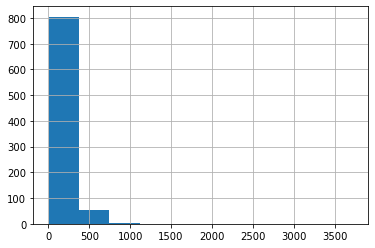

In [8]:
train["league_id"].value_counts().hist()

In [9]:
print(len(train["league_id"].unique()))

train["league_id"].value_counts()[train["league_id"].value_counts() > 200]

## We have only 202 from 862 league_id's with more than 200 occurences in the dataset 

862


1101    3725
9        858
1936     775
14       751
12       731
        ... 
1330     202
1314     202
1642     201
1261     201
1409     201
Name: league_id, Length: 202, dtype: int64

In [10]:
#League_id column
print("Number of unique league ids in training and test set", len(set(test["league_id"].unique()).union(set(train["league_id"].unique()))))

#symmetrical difference between league ids of the training set and the test set 
sym = set(train["league_id"].unique()).difference(set(test["league_id"].unique())).union(set(test["league_id"].unique()).difference(set(train["league_id"].unique())))
print("\nNumber of league ids in one set and not in the other (training and test set) : ", len(sym))

diff = set(test["league_id"].unique()).difference(set(train["league_id"].unique()))
print("\nNumber of league ids in test set and not in the training set (training and test set) : ", len(diff))

Number of unique league ids in training and test set 1000

Number of league ids in one set and not in the other (training and test set) :  255

Number of league ids in test set and not in the training set (training and test set) :  138


#### Droping useless columns :


In [77]:
cup_features = [col for col in train.columns if "cup" in col ]
coach_features = [col for col in train.columns if "coach" in col and "history" in col]
more_useless_features = [col for col in train.columns if "is_play_home" in col] 
less_important = ["id", "home_team_name","away_team_name" , "league_name", "home_team_coach_id", "away_team_coach_id",  "is_cup"]
less_important.extend( coach_features + cup_features + more_useless_features)

In [78]:
new_train = train.drop(less_important, axis=1)
new_test= test.drop(less_important, axis=1)

#### Dealing with NAN values : 

<AxesSubplot:>

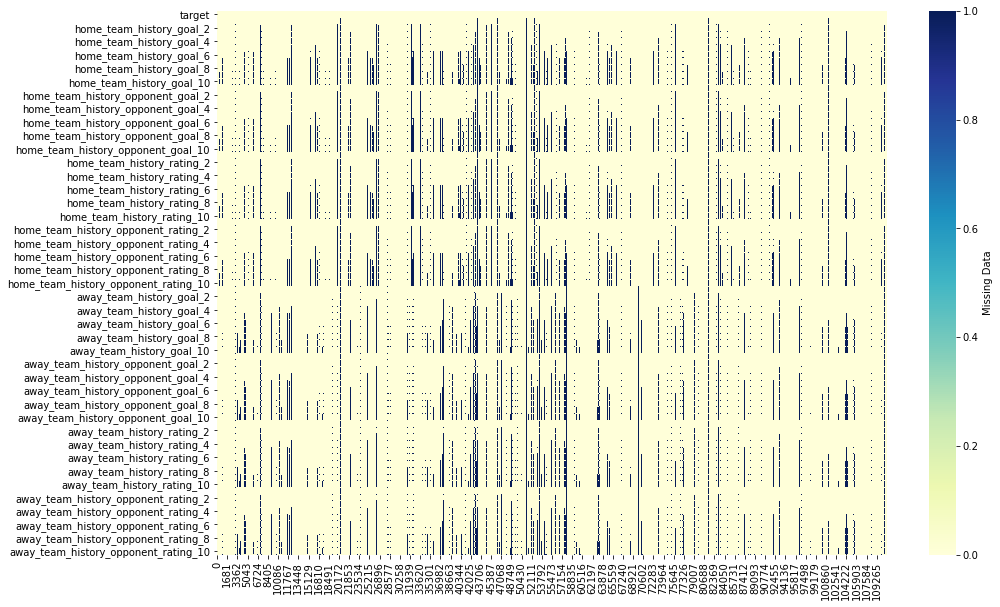

In [15]:
plt.figure(figsize=(15,10))
sns.heatmap(new_train.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

<AxesSubplot:>

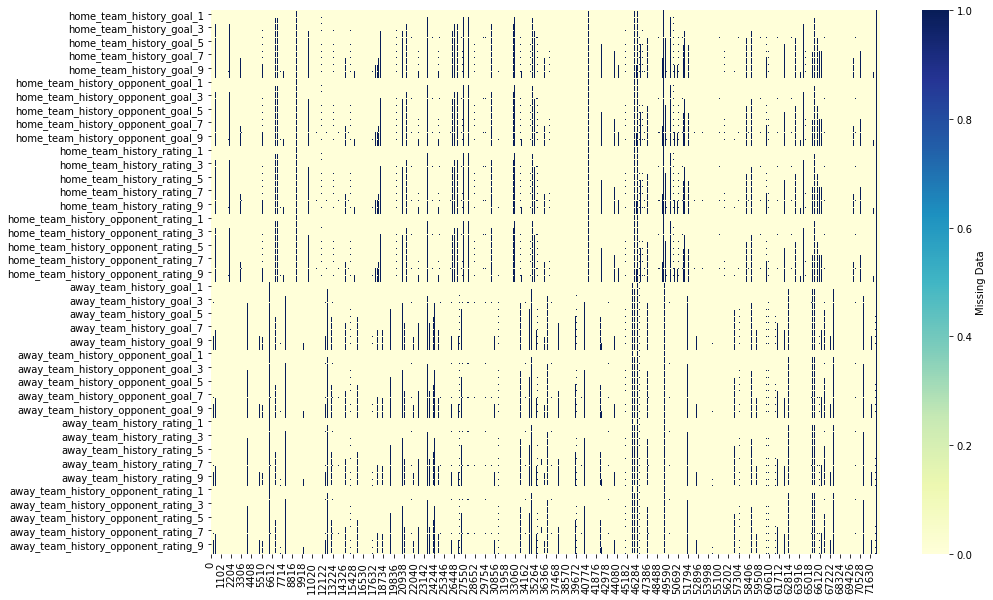

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(new_test.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [79]:
#number of columns with more than 5000 missing values 
sum(new_train.isna().sum() > 5000)

84

In [80]:
# Pourcentage des nulls toléré 
# nombre de collones avec plus que "pourcentage" de valeurs nulls
porucentage = 0.15
len(new_train.isna().sum()[new_train.isna().sum() > porucentage*new_train.shape[0]]) 

0

In [81]:
# Null values in the testset
new_test.isna().sum()[new_test.isna().sum() > 5000] 

home_team_history_match_date_9          5402
home_team_history_match_date_10         6064
home_team_history_goal_9                5402
home_team_history_goal_10               6064
home_team_history_opponent_goal_9       5402
home_team_history_opponent_goal_10      6064
home_team_history_rating_9              5415
home_team_history_rating_10             6080
home_team_history_opponent_rating_9     5415
home_team_history_opponent_rating_10    6080
home_team_history_league_id_9           5402
home_team_history_league_id_10          6064
away_team_history_match_date_9          5646
away_team_history_match_date_10         6308
away_team_history_goal_9                5646
away_team_history_goal_10               6308
away_team_history_opponent_goal_9       5646
away_team_history_opponent_goal_10      6308
away_team_history_rating_9              5658
away_team_history_rating_10             6318
away_team_history_opponent_rating_9     5658
away_team_history_opponent_rating_10    6318
away_team_

### Feature engineering : 

In [82]:
# get column names with string "date"
cols = [_ for _ in new_train.columns if 'date' in _]

# convert to datetime
for c in cols:
    new_train.loc[:, c] = pd.to_datetime(new_train.loc[:, c])
    new_test.loc[:, c] = pd.to_datetime(new_test.loc[:, c])
    

###### Creating a column that counts number of days since previous historical matchs for a game
###### for training and test set



In [86]:
for i in range(1,11):
    new_train.loc[:, f'home_days_since_match_{i}'] = (new_train['match_date'] - new_train[f'home_team_history_match_date_{i}']).dt.days
    new_train.loc[:, f'away_days_since_match_{i}'] = (new_train['match_date'] - new_train[f'away_team_history_match_date_{i}']).dt.days

cols = [_ for _ in new_train.columns if 'match_date' in _]
new_train.drop(cols, axis=1, inplace=True)


In [94]:
for i in range(1,11):
    new_test.loc[:, f'home_days_since_match_{i}'] = (new_test['match_date'] - new_test[f'home_team_history_match_date_{i}']).dt.days
    new_test.loc[:, f'away_days_since_match_{i}'] = (new_test['match_date'] - new_test[f'away_team_history_match_date_{i}']).dt.days

cols = [_ for _ in new_test.columns if 'match_date' in _]
new_test.drop(cols, axis=1, inplace=True)


###### Creating a column that calculates the goal difference
###### for training and test set


In [87]:
for i in range(1,11):
    new_train[f"home_team_history_result_{i}"] = new_train[f"home_team_history_goal_{i}"] - new_train[f"home_team_history_opponent_goal_{i}"]
    new_train[f"away_team_history_result_{i}"] = new_train[f"away_team_history_goal_{i}"] - new_train[f"away_team_history_opponent_goal_{i}"]
    new_train.drop([f"home_team_history_goal_{i}", f"home_team_history_opponent_goal_{i}", f"away_team_history_opponent_goal_{i}", f"away_team_history_goal_{i}"] ,axis=1, inplace=True)
#new_train[].apply(lambda row : row["home_team_history_goal_1"] > row["home_team_history_opponent_goal_1"] , axis=1)
#if new_train[f"home_team_history_result_1"]
#    new_train[f"home_team_history_result_1"]

In [88]:
for i in range(1,11):
    new_test[f"home_team_history_result_{i}"] = new_test[f"home_team_history_goal_{i}"] - new_test[f"home_team_history_opponent_goal_{i}"]
    new_test[f"away_team_history_result_{i}"] = new_test[f"away_team_history_goal_{i}"] - new_test[f"away_team_history_opponent_goal_{i}"]
    new_test.drop([f"home_team_history_goal_{i}", f"home_team_history_opponent_goal_{i}", f"away_team_history_opponent_goal_{i}", f"away_team_history_goal_{i}"] ,axis=1, inplace=True)


###### Creating a column that counts goal difference over the last 10 games
###### for training and test set

In [89]:
home_goal_columns = [f"home_team_history_result_{i}" for i in range(1,11)]
away_goal_columns = [f"away_team_history_result_{i}" for i in range(1,11)]

In [90]:
new_train[f"home_team_history_goal_difference_10_matches"] = new_train[home_goal_columns].apply(np.sum, axis=1)
new_train[f"away_team_history_goal_difference_10_matches"] = new_train[away_goal_columns].apply(np.sum, axis=1)

In [91]:
new_test[f"home_team_history_goal_difference_10_matches"] = new_test[home_goal_columns].apply(np.sum, axis=1)
new_test[f"away_team_history_goal_difference_10_matches"] = new_test[away_goal_columns].apply(np.sum, axis=1)

In [92]:
new_train.head()

,target,league_id,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,...,home_team_history_result_7,away_team_history_result_7,home_team_history_result_8,away_team_history_result_8,home_team_history_result_9,away_team_history_result_9,home_team_history_result_10,away_team_history_result_10,home_team_history_goal_difference_10_matches,away_team_history_goal_difference_10_matches
0,away,636,3.856860,5.724370,4.335091,6.678853,5.478300,5.858534,3.641945,7.957243,...,0.0,0.0,2.0,2.0,0.0,2.0,3.0,2.0,3.0,7.0
1,home,752,13.668800,5.967622,9.130611,5.732981,7.804064,6.743764,6.237028,12.616250,...,-1.0,-4.0,2.0,0.0,-1.0,-1.0,0.0,3.0,-1.0,-6.0
2,draw,734,5.736719,9.745283,5.685920,6.975000,3.864360,7.930120,4.650054,12.803284,...,0.0,0.0,1.0,1.0,-2.0,4.0,0.0,0.0,2.0,10.0
3,away,743,5.998800,5.860496,8.256900,8.342183,6.163600,8.097475,5.796913,10.739525,...,1.0,1.0,0.0,-1.0,-1.0,1.0,0.0,-1.0,5.0,4.0
4,home,705,6.295743,7.625358,5.320906,7.425725,4.854167,10.857700,5.756838,7.079583,...,1.0,-2.0,0.0,1.0,-1.0,4.0,0.0,0.0,4.0,8.0


In [95]:
new_test.head()

,league_id,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,...,home_days_since_match_6,away_days_since_match_6,home_days_since_match_7,away_days_since_match_7,home_days_since_match_8,away_days_since_match_8,home_days_since_match_9,away_days_since_match_9,home_days_since_match_10,away_days_since_match_10
0,755,4.134982,5.579979,4.604694,4.405645,3.802064,4.641138,4.703983,4.218740,4.382131,...,24.0,47.0,29.0,51.0,41.0,54.0,45.0,63.0,48.0,70.0
1,743,5.174083,6.889300,6.160500,4.576700,6.855450,4.926512,3.820850,4.743661,4.506815,...,45.0,48.0,53.0,55.0,56.0,59.0,62.0,62.0,69.0,68.0
2,1314,4.643155,3.583563,4.908508,3.728650,3.004767,5.731775,4.453211,4.952475,5.205167,...,51.0,51.0,54.0,55.0,61.0,62.0,243.0,165.0,247.0,168.0
3,1314,5.304272,4.496475,4.462217,3.100038,5.863264,4.697505,4.388908,3.939061,5.348738,...,51.0,51.0,55.0,55.0,59.0,61.0,243.0,135.0,248.0,138.0
4,1314,3.790810,3.070258,7.727192,4.576100,4.932440,4.570435,5.805843,7.589273,3.961558,...,51.0,51.0,55.0,54.0,59.0,62.0,227.0,231.0,234.0,238.0


## Training of our models : 

In [96]:
x = new_train.drop("target", axis=1)
x = x[:]
y = new_train["target"]
y = y[:]

nbr_features = x.shape[1]

In [97]:
new_train.shape

(110938, 104)

In [98]:
test_size=0.2
random_state=21
X_train, X_cv, y_train, y_cv = train_test_split(x, y, test_size=test_size, random_state=random_state)

#### XGBoost Model :

In [99]:
# This set of parameters has been chosen with cross validation over what we called here X_cv and y_cv
# To better explore the parameters space and not waste time training many models in vane, we tried to tweak the parameters 
# manually to better explore this space, for example when we see that our model is overfitting the dataset, we don't need to 
# to try to increase the number of estimators (n_estimators) or increase the learning rate.
# we keep track of all our results in a file "results.csv"

params = {'n_estimators' : 600,
            'max_depth' : 2,
          "learning_rate" : 0.08
         }
xgbModel = XGB.XGBClassifier(objective='multi:softprob', random_state=random_state,verbosity=1, **params)

In [ ]:
start = time.time()
xgbModel.fit(X_train, y_train)
end = time.time()
cross_val_fit_time = round((end-start)/60, 2)
print("\nExecution time in minutes: {:.2f}".format(cross_val_fit_time))

C:\Users\yacin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:11:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [58]:
predictions_cv = xgbModel.predict_proba(X_cv) 
log_loss_error_cv = log_loss( y_cv , predictions_cv)     # multinomial log-loss estimation on the training set
print("Multinomial log loss error on Cross validation is : ",log_loss_error_cv)

Multinomial log loss error on Cross validation is :  1.0143756481202841


In [39]:
predictions_train = xgbModel.predict_proba(X_train) 
log_loss_error_train = log_loss( y_train , predictions_train)     # multinomial log-loss estimation on the training set
print("Multinomial log loss error on the training set is : ",log_loss_error_train)

Multinomial log loss error on the training set is :  0.9931203945727626


In [191]:
f = open("results.csv" , "a")

#First line in the file
#f.write(f"n_estimators, max_depth, learning_rate, nbr_features, test_size, random_state,  log_loss_error_cv, log_loss_error_train, cross_val_fit_time, features_used ")

f.write(f"\n{params['n_estimators']}, {params['max_depth']}, {params['learning_rate']}, {nbr_features}, {test_size}, {random_state},   {log_loss_error_cv:.5f},  {log_loss_error_train:.5f}, {cross_val_fit_time}, {x.columns.tolist()}")
f.close()

In [79]:
xgbModel = XGB.XGBClassifier(objective='multi:softprob', random_state=22,verbosity=1)
parameters = {
    'n_estimators' : [600,],
    'max_depth':[2, 3 ],
}

In [172]:
grid = GridSearchCV(estimator = xgbModel, param_grid = parameters, scoring='neg_log_loss', cv= 3, n_jobs=-1, verbose=4, return_train_score=True)

SyntaxError: invalid syntax (<ipython-input-172-6c1e475c4fd4>, line 1)

In [81]:
grid.fit(x, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 11.5min remaining: 11.5min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 14.7min finished
C:\Users\yacin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:34:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:34:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:34:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:34:50

[18:34:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:34:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:34:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:34:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:34:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:34:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:35:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:35:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:35:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:35:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:35:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:35:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:35:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:35:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:35:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:35:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:35:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:36:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:36:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:36:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:36:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:36:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:36:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:36:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:36:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:36:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:36:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned

[18:36:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:36:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:37:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:37:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:37:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:37:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:37:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:37:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:37:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:37:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:37:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:37:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:38:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:38:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:38:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[18:38:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:38:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None,
                                     random_state=22, reg_alpha=None,
       

In [82]:
#results with 102 features and all datapoints minus null
res = pd.DataFrame(grid.cv_results_)
res[["params","mean_fit_time",'mean_train_score','mean_test_score']]

,params,mean_fit_time,mean_train_score,mean_test_score
0,"{'max_depth': 2, 'n_estimators': 600}",683.474525,-0.943830,-1.028094
1,"{'max_depth': 3, 'n_estimators': 600}",873.209436,-0.844335,-1.040841


In [188]:
best = grid.best_estimator_

In [153]:
xgbModel.fit(x,y)

C:\Users\yacin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.08, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=360, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=1)

In [163]:
pp = xgbModel.predict_proba(x) 

In [164]:
log_loss_error = log_loss( y , pp)     # multinomial log-loss estimation on the training set
print(log_loss_error)

0.9847986581627773


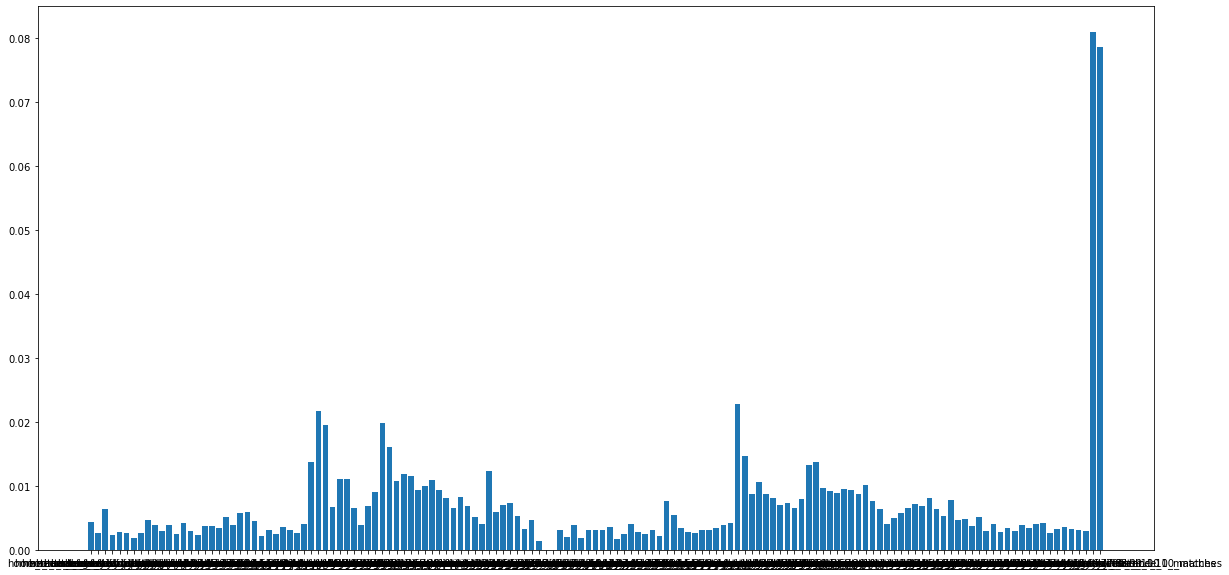

In [165]:
plt.figure(figsize=(20,10))
plt.bar(x.columns[:], xgbModel.feature_importances_[:], )
plt.show()

In [166]:
feature_importance_serie = pd.Series(index = x.columns[:], data= xgbModel.feature_importances_[:], )
feature_importance_serie[feature_importance_serie < 0.005]

league_id                           0.004343
home_team_history_is_play_home_1    0.002625
home_team_history_is_play_home_3    0.002278
home_team_history_is_play_home_4    0.002828
home_team_history_is_play_home_5    0.002648
                                      ...   
away_team_history_result_8          0.003304
home_team_history_result_9          0.003622
away_team_history_result_9          0.003288
home_team_history_result_10         0.003083
away_team_history_result_10         0.003026
Length: 77, dtype: float32

In [167]:
predictions = xgbModel.predict_proba(new_test) 

In [168]:
predictions.mean(axis=0)

array([0.3207798 , 0.24521723, 0.43400544], dtype=float32)

In [169]:
submission = pd.DataFrame(predictions ,columns=xgbModel.classes_)

#do not forget the id column
submission['id'] = test['id']
assert submission.shape[0]== 72711
#submit!
submission.to_csv('./submissions/submission6.csv', index=False)
submission.head()

,away,draw,home,id
0,0.259205,0.335596,0.405200,17761448
1,0.338996,0.305847,0.355157,17695487
2,0.296847,0.303067,0.400086,17715496
3,0.472006,0.326264,0.201730,17715493
4,0.248639,0.297770,0.453591,17715492
